

# Projet Python

All the scripts are available  <a href="https://github.com/victorjourne/Python-Project">on the github page</a>.

## Motivation
Facial expression recognition is an important and challenging task to achieve a successful human-computer interaction system.
The American psycholigist Paul Ekman demonstrated that there exists six universal emotional labels that fit facial expressions accross all cultures. Those facial expression are: anger, disgust, fear, happiness, sadness and surprise.
After the success of convolutional neural networks (CNNs) in image classification, these models as been extended to facial expression recognition. The main advantage of using these deep learning algorithms is that CNN learns to extract the features directly from the training database.
The aim of this project is to implement deep neural networks to learn the computer to recongnize facial expression.

## Introduction
### Database
For this project, we use the database from the <a href="https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge">Kaggle Facial Expression Recognition Challenge</a>. The database consists of **35887 48-by-48-pixel grayscale images**. Each face is labeled with one of the following seven emotions: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral.<br />
The database is divided into three sets:
- a **training set** of 28709 examples;
- a **public test** of 3589 examples;
- a **private test** of 3589 examples.
<br />
<br />
Contrary to Kaggle competitors who had only access to the training and the public sets, we have also access to the private set. To put ourselves under the same conditions as Kaggle competitors, we will only use the training set and the public set to train our models and use the private set to test the accuracy of our model.

### Model: Convolutional Neural Network (CNN)

In the field of computer vision such as pattern recognition, neuronal networks are getting more and more popular.
We have chosen for this project a convolutional neural network which imitates the brain's working.

<img src="CNNArchitecture.jpg">

The network is made up with several different nature of layers. The feature extraction part gathers convolutional layers acting as local pattern matching and subsampling layers used for dimensionality reduction. This part is plugged with a final classification layer of fully connected neurons.


## Data exploration

In [ ]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
from skimage import exposure,transform
from sklearn import preprocessing
from sklearn.externals import joblib

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.regularizers import l2

%matplotlib inline

After Importing libraries, the data are loaded from its original format, available on the Kaggle challange page.

In [3]:
np.random.seed(1337)  # for reproducibility

DATA_PATH = os.environ['EMOTION_PROJECT']
#DATA_PATH = "/Users/ludoviclelievre/Documents/cours_ensae_ms/python_pour_le_dataScientist/projet_python/donnees/fer2013"
#DATA_PATH = "mypath"
GIT_PATH = "C:\Users\KD5299\Python-Project"
#GIT_PATH = "/Users/ludoviclelievre/Documents/Python-Project"

df0 = pd.read_csv(os.path.join(DATA_PATH,'fer2013.csv'), 
                     sep=",")
df0.drop('pixels',axis = 1,inplace=True)
df1 = pd.read_csv(os.path.join(DATA_PATH,'pixels.csv'), 
                             sep=" ", header=None)

df = pd.merge(df0,df1,left_index=True,right_index=True)
# dico emotion
dico_emotion = {0:'Angry',1:'Disgust', 2:'Fear',
                3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

print("Successful load")

Successful load


### import data

In order to easily manipulate, transform and view images from the initial database, we have define a class as follows:

In [4]:

class Data:
    def __init__(self,df):
        self.data_emotion = df['emotion'].as_matrix(columns=None)
        self.data_usage = df['Usage'].as_matrix(columns=None)
        self.data_image = df[list(filter(lambda pxl: type(pxl)!=str ,df.columns.tolist()))].as_matrix(columns=None)
   
    @property
    def nb_example(self):
        return int(self.data_emotion.shape[0])
    @property
    def dim(self):
        return int(np.sqrt(self.data_image[0].shape[0]))     
    @property
    def nb_classes(self):
        return int(np.unique(self.data_emotion).shape[0])
    @property
    def input_shape(self):
        if K.image_dim_ordering() == 'th':
            return (1, self.dim, self.dim)
        else:
            return (self.dim, self.dim,1)
    
    def CreateUsageSet(self,usage):
        mask = np.in1d(self.data_usage, usage)
        X = self.data_image[mask, :]
        Y = self.data_emotion[mask]
    
        if K.image_dim_ordering() == 'th':
            X = X.reshape(X.shape[0], 1,self.dim, self.dim)
        else:
            X = X.reshape(X.shape[0], self.dim, self.dim, 1)
        X = X.astype('float32')
        Y = np_utils.to_categorical(Y, self.nb_classes)
        return X,Y

    def zoom(self,z):
        data_image_zoom = np.ndarray((self.data_image.shape[0],
                                      self.data_image.shape[1]/z**2))
        i = 0
        for image in self.data_image:
            data_image_zoom[i] = transform.downscale_local_mean(
                            image.reshape((self.dim, self.dim)),(z,z)).ravel()
            i=1+i
        self.data_image = data_image_zoom    
#        self.dim = int(self.dim / z)
        
    def EnhanceContrast(self):
        self.data_image = np.apply_along_axis(
                                exposure.equalize_hist,1,self.data_image)
        
    def Normalize(self):
        self.data_image =self.data_image/255.

            
    def ViewOneEmotion(self,usage,example,ax):
#        fig = plt.figure()
#        ax = fig.add_subplot(111)
        image = self.data_image[self.data_usage==usage][example]
        emotion = self.data_emotion[example]
        pixels = image.reshape(self.input_shape[0:2])
        ax.imshow(pixels, cmap='gray')
        ax.set_title(dico_emotion[emotion])
        plt.axis('off')
        return ax

    def ViewSomeEmotions(self,usage,example_list):
    
        fig = plt.figure(figsize=(16,8))
        i = 1
        nrow = int(np.sqrt(len(example_list)+.25)-0.5)+1
        for example in example_list:
            ax = fig.add_subplot(nrow,nrow+1,i)
            ax = self.ViewOneEmotion(usage,example,ax)
            i = i+1 
    
    def ViewEmotionPredictions(self,usage,example_list,prediction_matrix):
        nrow = 2*(int(np.sqrt(len(example_list)+.25)-0.5)+1)
        ncol = (2*len(example_list))/nrow+1
        fig = plt.figure(figsize=(12,12))
        i = 1
        for example in example_list:
            ax = fig.add_subplot(nrow,ncol,i)
            ax = self.ViewOneEmotion(usage,example,ax)
            ax1 = fig.add_subplot(nrow,ncol,i+ncol)
            ax1.bar(range(0,self.nb_classes), prediction_matrix[example],color =colors)
            ax1.set_xticks(np.arange(0.5,6.5,1))
            ax1.set_xticklabels(dico_emotion.values(), rotation=45, fontsize=7)
            ax1.set_yticks(np.arange(0.0,1.1,0.5))
#            if i%ncol==0:
#                i = i+ncol
            i = i+1+ncol*(i%ncol==0)
        plt.tight_layout()

    # Substract the mean value of each image
    def SubstractMean(self):
        mean = self.data_image.mean(axis=1)
        self.data_image = self.data_image - mean[:, np.newaxis]

    # set the image norm to 100 and standardized each pixels accross the image    
    def Normalization(self):
        # set the image norm to 100 
        min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
        self.data_image = min_max_scaler.fit_transform(self.data_image)
        # standardized each pixels accross the image
        scaler = preprocessing.StandardScaler().fit(self.data_image[self.data_usage=='Training'])
        self.data_image = scaler.transform(self.data_image)

    def FlipTrain(self,usage):
        flip_image = self.data_image[self.data_usage==usage]*0
        i = 0
        for image in self.data_image[self.data_usage==usage]:
            flip_image[i] = np.fliplr(
                    image.reshape(self.input_shape[0:2])).ravel()
            i=1+i
        flip_emotion = self.data_emotion[self.data_usage==usage]
        flip_usage = self.data_usage[self.data_usage==usage]+" flip"

        self.data_image = np.concatenate(
                    (self.data_image,flip_image),axis=0)
        self.data_emotion = np.concatenate(
                    (self.data_emotion,flip_emotion),axis=0)     
        self.data_usage = np.concatenate(
                    (self.data_usage,flip_usage),axis=0)
        
 

This class is convenient to process images as a whole, for instance we can call to use 8 images randomly in the training set:

The subset is shaped as (48, 48, 1)
The subset has 8 examples
The subset has 5 different classes


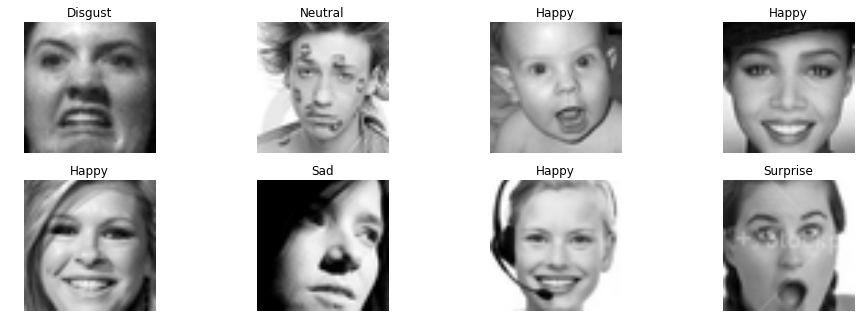

In [5]:
some_images = Data(df[df['Usage']=='Training'].sample(8))
print('The subset is shaped as {}'.format(some_images.input_shape))
print('The subset has {} examples'.format(some_images.nb_example))
print('The subset has {} different classes'.format(some_images.nb_classes))
# see the 8th first images of the training set
some_images.ViewSomeEmotions('Training',range(8))

### Preprocessing

Before applying a Convolutional Neural Network on these images, we need to preprocess them. We tried several preprocessing techniques and tested them on the cross validation set. We retained the data preprocessing used by Yichuan Tang in his paper <a href="https://arxiv.org/pdf/1306.0239.pdf">Deep Learning using Linear Support Vector Machines.</a>

SubstractMean:<br />
We have observed that the images from the database do not have the same grayscale intensities: some images are darker than others. We decide to **set each sample mean to 0** to have the same intensities across each sample and **set the image norm to 100**.

Normalization:<br />
Besides, CNNs are more efficient when data are normalized. To do so, we normalize each pixels in the training set by **removing its mean and dividing its value by the standard deviation of that pixel**. We then compute the standardization on the public set and the private set using the transformation scaler from the training set.

Zoom:<br />
To speed up the manual CNN parametrization, **we have divided by 2** the image size. Each new pixel is the mean of its four neighbours.

Let's apply these data transformations on the previous images and visualize them.

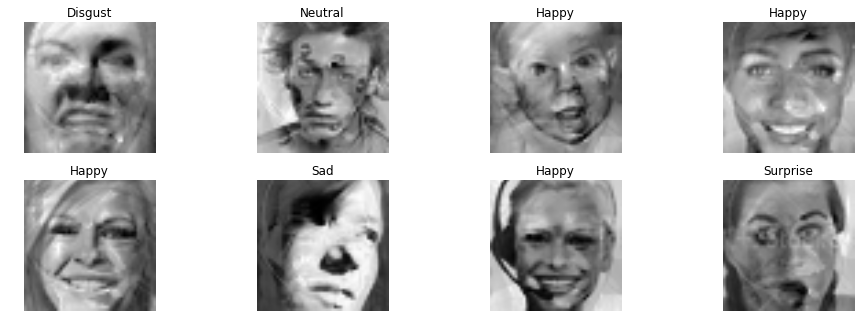

In [6]:
some_images.SubstractMean()
some_images.Normalization()
#some_images.zoom(2)
some_images.ViewSomeEmotions('Training',range(8))

### Unbalanced dataset
As exploring the dataset, we discovered that there were very few examples of the "disgust" class compared to the other emotion classes. We plot the histogram to show the unbalance of the dataset.

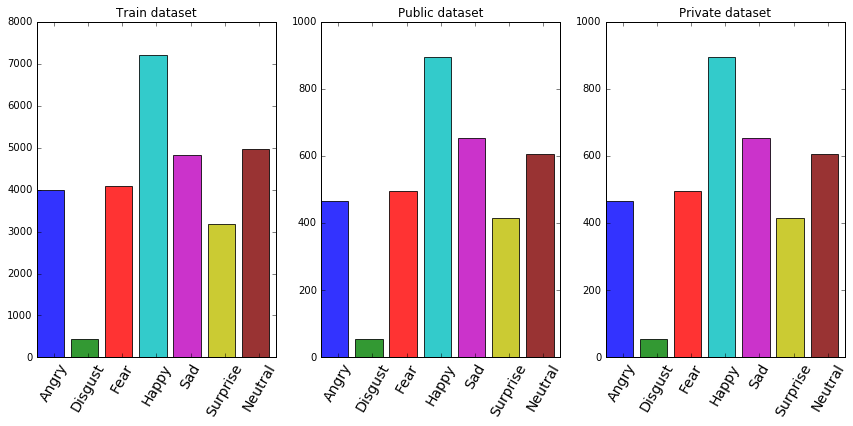

In [7]:
labels1 =dico_emotion.values()
data = Data(df)
y_train_labels  =data.data_emotion[data.data_usage=='Training']
y_cv_labels = data.data_emotion[data.data_usage=='PublicTest']
y_test_labels = data.data_emotion[data.data_usage=='PrivateTest']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'maroon']

def plot_distribution_unbalanced(ytrain, ycv, ytest, data_names): 
    fig = plt.figure(figsize=(12,6))
    ylims =[8000,1000]
    # training set
    ax1 = fig.add_subplot(1,3,1)
    ax1.bar(np.arange(0,7), np.bincount(ytrain), color=colors, alpha=0.8)
    ax1.set_xticks(np.arange(0.5,7.5,1))
    ax1.set_xticklabels(labels1, rotation=60, fontsize=14)
    ax1.set_xlim([0, 7])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    # cv set
    ax2 = fig.add_subplot(1,3,2)
    ax2.bar(np.arange(0,7), np.bincount(ycv), color=colors, alpha=0.8)
    ax2.set_xticks(np.arange(0.5,7.5,1))
    ax2.set_xticklabels(labels1, rotation=60, fontsize=14)
    ax2.set_xlim([0, 7])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    # test set
    ax2 = fig.add_subplot(1,3,3)
    ax2.bar(np.arange(0,7), np.bincount(ycv), color=colors, alpha=0.8)
    ax2.set_xticks(np.arange(0.5,7.5,1))
    ax2.set_xticklabels(labels1, rotation=60, fontsize=14)
    ax2.set_xlim([0, 7])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[2])
    plt.tight_layout()
    plt.show()
    
plot_distribution_unbalanced(y_train_labels, y_cv_labels, y_test_labels, ['Train dataset', 'Public dataset', 'Private dataset']) 

To prevent from misclassifying the images of the "disgust" class due to the very few examples we have to train our model on, we decided to drop this class and implemeent our classification on the six remaining classes.

In [8]:
data = Data(df[df['emotion']!=1])
f = lambda x: x-1 if x>1 else x
fv = np.vectorize(f)
data.data_emotion = fv(data.data_emotion)
# new dictionary from now, with disgust removed
dico_emotion = {0:'Angry', 1:'Fear',
                2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}


## First model

First, we have to apply the data preprocssing on the inputs as described above and split the database into the train set, the cross validation set and the test set. The method CreateUsageSet permits to reshape the images and the targets the way keras is expecting.

In [9]:
# processing
data.SubstractMean()
data.Normalization()
data.zoom(2)
# Create usage set
Xtrain, YtrainBin = data.CreateUsageSet('Training')
Xcv, YcvBin = data.CreateUsageSet('PublicTest')
Xtest, YtestBin = data.CreateUsageSet('PrivateTest')
print("Sets created")

Sets created


In [10]:
print(YtrainBin.shape)

(28273L, 6L)


Then we have to choose the tuning parameters.<br /> 
We set the number of filters to 16 and the window size of these filters to 3x3. The Max-Pooling layer applies on a window of size 2x2. To speed up the optimization, we set the batch size to 128.

In [11]:
### parameters CNN ###
batch_size = 128
nb_epoch = 3
# input image dimensions
img_rows, img_cols = data.dim,data.dim
# number of convolutional filters to use
nb_filters = 16
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)


Finally, we build our Convolutional Neural Network.<br /> 
The network consists of two convolution layers, one Max-Pooling layer, followed by two fully connected layers. We use the ReLU activation fonction except for the last layer where the softmax function is used. Two dropout layers are introduced to reduce the risk of overfitting. A categorical cross_entropy method is used as the cost function and is optimized using adadelta.

In [12]:
# CNN model
model = Sequential()
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=data.input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(data.nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# Model fitting
model.fit(Xtrain, YtrainBin, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(Xcv, YcvBin))

Train on 28273 samples, validate on 3533 samples
Epoch 1/3
28273/28273 [==============================] - 19s - loss: 1.6885 - acc: 0.3040 - val_loss: 1.5829 - val_acc: 0.3578
Epoch 2/3
28273/28273 [==============================] - 19s - loss: 1.5775 - acc: 0.3683 - val_loss: 1.4949 - val_acc: 0.4110
Epoch 3/3
28273/28273 [==============================] - 19s - loss: 1.5154 - acc: 0.4022 - val_loss: 1.4474 - val_acc: 0.4416


We have set the number of epochs to 3 to give an example of how the CNN fitting step works.

### Model24

The model is a bit long to train (15 min at least, with a cpu compiler), that is why the coefficients of the CNN have been saved and available on the github project.<br />
A loaded model is used instead:

In [18]:
# Local path of the cloned github folder at 
# https://github.com/victorjourne/Python-Project.git
GIT_PATH = "C:\Users\KD5299\Python-Project"
model24 = load_model(os.path.join(GIT_PATH,'model24'))
history24 = pickle.load(open( os.path.join(GIT_PATH,'history24'), "rb" ))

print("model successfully loaded")

model successfully loaded


### Plot intermediate layers

We can plot layers response to an particular input, with Theano and Keras module.
The first layer is a 16 convolutional filters.
the second one is the output of the max function applied to the first layer.
The third one is again a convolutional layer.
The last plot depicts the maxpooling step, where the shape of the input is divided by 2.

shape of this layer: (22L, 22L, 16L)


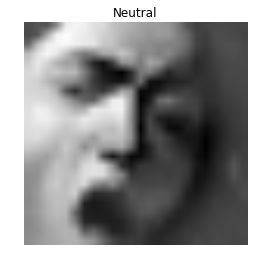

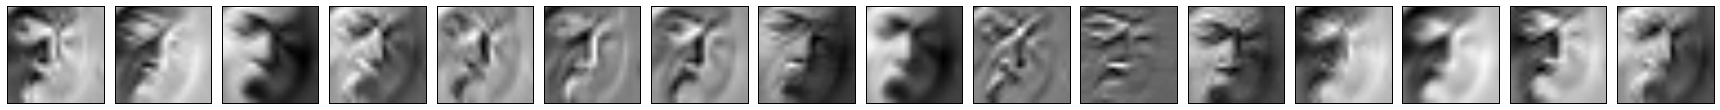

shape of this layer: (22L, 22L, 16L)


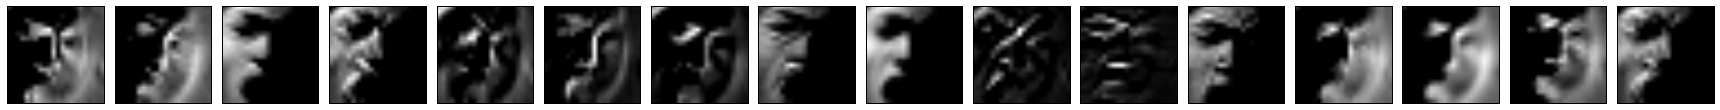

shape of this layer: (20L, 20L, 16L)


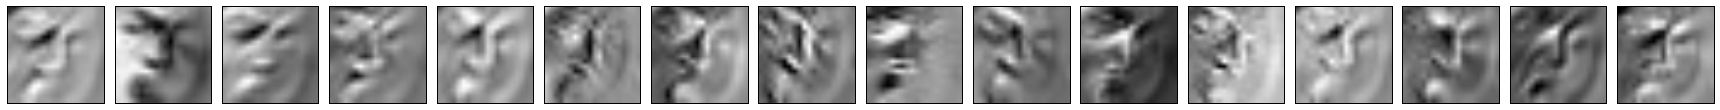

shape of this layer: (20L, 20L, 16L)


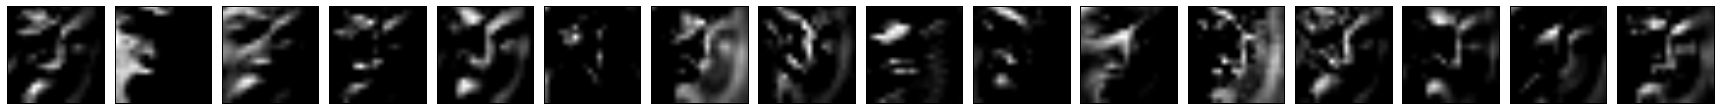

shape of this layer: (10L, 10L, 16L)


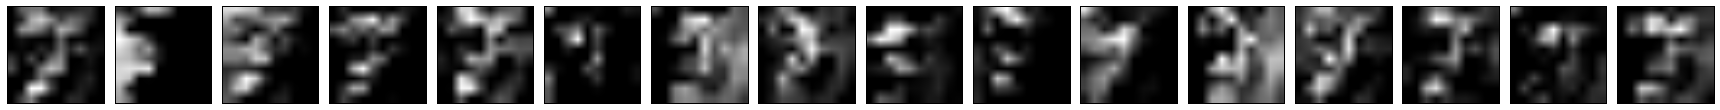

In [15]:

import theano
def plot_interlayer_outputs(input_img, layer_num1, layer_num2):
    output_fn = theano.function([model.layers[layer_num1].input], # import theano
                                 model.layers[layer_num2].output, allow_input_downcast=True)
    im = output_fn(input_img).squeeze() #filtered image
    print("shape of this layer: {}".format(im.shape))
    n_filters = im.shape[-1]
    fig = plt.figure(figsize=(24,12))
    for i in range(n_filters):
        ax = fig.add_subplot(n_filters/16,16,i+1)
        ax.imshow(im[:,:,i], cmap='gray') 
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

# plot the 4th image of the PrivateTest set
example = 4
fig = plt.figure()
ax = fig.add_subplot(111)
data.ViewOneEmotion('PrivateTest',example,ax)

img = Xtest[example:example+1]
plot_interlayer_outputs(img, 0, 0)
plot_interlayer_outputs(img, 0, 1)
plot_interlayer_outputs(img, 0, 2)
plot_interlayer_outputs(img, 0, 3)
plot_interlayer_outputs(img, 0, 4)





Moreover, the 16 convolutional filter kernels of the first layer can be seen with this code:

('W shape : ', (3L, 3L, 16L))


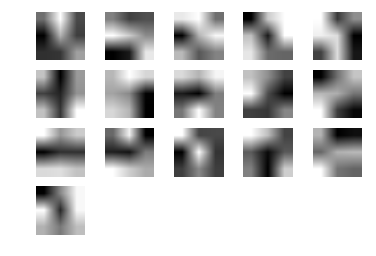

In [16]:
# Visualize weights
W = model.layers[0].W.get_value(borrow=True)
W = np.squeeze(W)
print("W shape : ", W.shape)

fig = plt.figure()
nrow = int(np.sqrt(nb_filters+.25)-0.5)+1
for i in range(nb_filters):
    ax = fig.add_subplot(nrow,nrow+1,i+1)
    pixels = W[:,:,i]
    ax.imshow(pixels, cmap='gray')
    ax.grid(color='r', linestyle='-', linewidth=1)
    ax.axis('off')
    i = i+1

The filters of the first layer have 9 weigths and were determined by learning from the Training dataset. We can observe some locally patterns such as lines or arcs. 

### accuracy, plot accuracy, confusion matrix, 

First, we show the accuracy of the model on the cross validation set and on the test set. We then plot the evolution of the accuracy of the train set and the cross validation set across the epochs. 

('CV score:', 1.2159592256038545)
('CV accuracy:', 0.53948485706198701)
('Test score:', 1.1978440095829168)
('Test accuracy:', 0.53140916808149408)


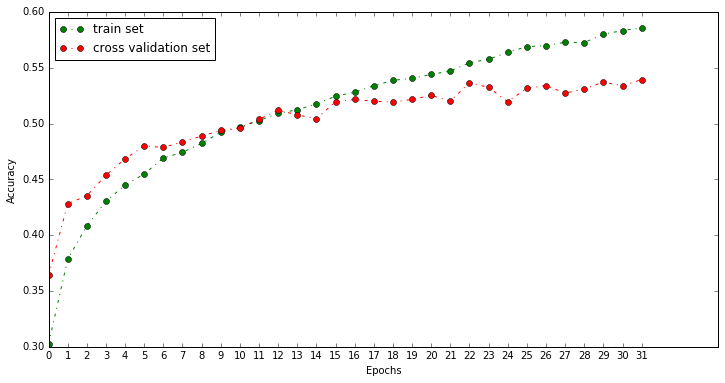

In [19]:
scoreCV = model24.evaluate(Xcv, YcvBin,verbose=0)
scoreTest = model24.evaluate(Xtest, YtestBin, verbose=0)

# Cross validation score and accuracy
print('CV score:', scoreCV[0])
print('CV accuracy:', scoreCV[1])
# Test score and accuracy
print('Test score:', scoreTest[0])
print('Test accuracy:', scoreTest[1])

# Plot evolution of accuracy
def plot_accuracy(serie1, serie2, set_name):
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(111)
    ax1.plot(serie1,color='g',marker='o',linestyle='-.',label=set_name[0])
    ax1.plot(serie2,color='r',marker='o',linestyle='-.',label=set_name[1])
    ax1.set_xticks(range(0,len(serie1),1))
    # changer les labels
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    
    ax1.legend(loc='best')
    
plot_accuracy(history24['acc'], history24['val_acc'], set_name = ['train set', 'cross validation set'])

The model reaches an accuracy on the test set of 0.5314. This means that the model correctly classifies 53.14% of the image in the test set. This is already a satisfying result since it is far above the random classification. Indeed, our classification exercice contains 6 different classes, which implies that a random classifier would correctly classify only 16.66% of the images.<br />
From the graph, we can see that the model starts overfitting at epoch 15. The accuracy of the train set is rising much more faster than the accuracy of the test set.

Let's go deeper in the analysis of the classification of the model by showing the classification report and the confusion matrix.

             precision    recall  f1-score   support

          0       0.45      0.42      0.43       491
          1       0.39      0.26      0.31       528
          2       0.68      0.79      0.73       879
          3       0.37      0.39      0.38       594
          4       0.69      0.65      0.67       416
          5       0.50      0.54      0.52       626

avg / total       0.52      0.53      0.52      3534



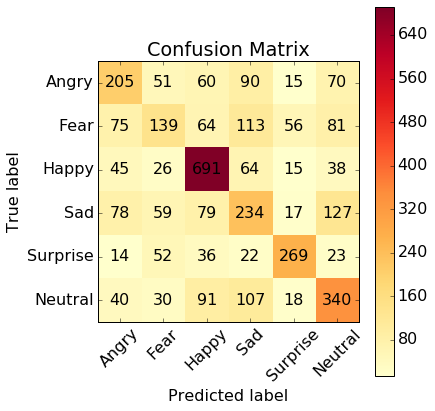

In [20]:
from sklearn import metrics 
# Model evaluation
Ypred = model24.predict_classes(x=Xtest, batch_size=batch_size, verbose=0)
Ytest = data.data_emotion[data.data_usage=='PrivateTest']
labels = dico_emotion.values()

# Classification report
print(metrics.classification_report(Ytest, Ypred))

# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlOrRd):
    cm = metrics.confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(Ytest, Ypred)


From the f1-score of the classification report, we can see that the "happy" and the "surprise" classes are the two classes the model classifies the best. On the contrary, the model struggles classifying the "fear" and the "sad" classes. The confusion matrix helps analyzing the misclassification: the "fear" images are often classified as "sad" and the "sad" images are often classified as "neutral".

## Better models?

### Flipped images sensitivity

Is it relevent to flip the train set? That is to say get the mirror image for each? Test of accuracy with model24. <br />
We flip **PublicTest set** to see the sensitivity of model24 to this transformation

In [21]:
# Accuracy on the Public Test set
Xcv, YcvBin = data.CreateUsageSet('PublicTest')
scoreTest = model.evaluate(Xcv, YcvBin , verbose=0)
print('Test accuracy:', scoreTest[1])
data.FlipTrain('PublicTest')

# Flip the PublicTest set
Xcvflip,_ = data.CreateUsageSet('PublicTest flip')
scoreTest = model.evaluate(Xcvflip, YcvBin , verbose=0)
print('Test accuracy on the flipped PublicTest:', scoreTest[1])



('Test accuracy:', 0.44155108972544582)
('Test accuracy on the flipped PublicTest:', 0.4288140390602887)


There is 2% of difference, it can be relevent to enrich the Training dataset by flipping all images. As a result, the Training dataset is twice bigger.

### Comparison model24 and modelflip24

The same model architecture was used for the training of modelflip24 and its weights are saved in the Github folder.

In [22]:
modelflip24 = load_model(os.path.join(GIT_PATH,'modelflip24'))
historyflip24 = pickle.load(open( os.path.join(GIT_PATH,'historyflip24'), "rb" ))

('CV score:', 1.1825767184262097)
('CV accuracy:', 0.54882536088310219)
('Test score:', 1.1798041389024925)
('Test accuracy:', 0.54668930390492365)


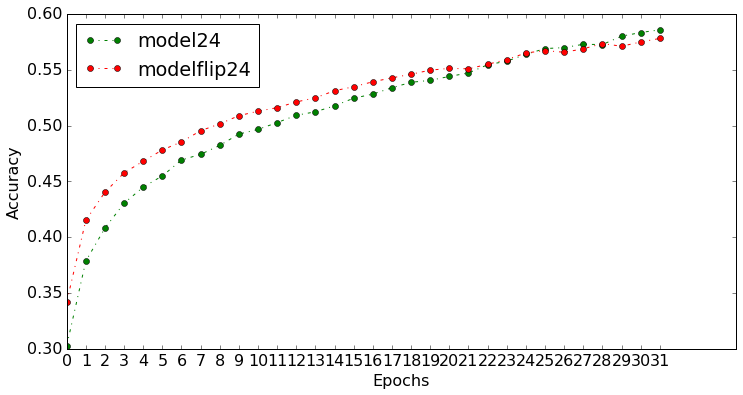

In [24]:
scoreCVflip24 = modelflip24.evaluate(Xcv, YcvBin,verbose=0)
scoreTestflip24 = modelflip24.evaluate(Xtest, YtestBin, verbose=0)

# Cross validation score and accuracy
print('CV score:', scoreCVflip24[0])
print('CV accuracy:', scoreCVflip24[1])
# Test score and accuracy
print('Test score:', scoreTestflip24[0])
print('Test accuracy:', scoreTestflip24[1])

# Plot comparison model24 modelflip24
plot_accuracy(history24['acc'], historyflip24['acc'], set_name = ['model24', 'modelflip24'])

The modelflip24 learns faster than model24, but have similar accuracy after 25 epochs. They overfit in the same time.

             precision    recall  f1-score   support

          0       0.48      0.41      0.44       491
          1       0.46      0.20      0.28       528
          2       0.67      0.83      0.74       879
          3       0.40      0.40      0.40       594
          4       0.73      0.63      0.67       416
          5       0.47      0.63      0.54       626

avg / total       0.54      0.55      0.53      3534



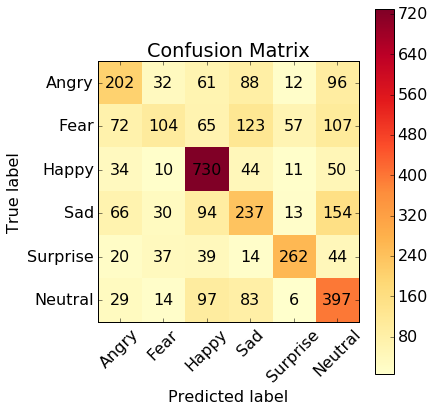

In [26]:
# Model evaluation
Ypredflip24 = modelflip24.predict_classes(x=Xtest, batch_size=batch_size, verbose=0)
Ytestflip24 = data.data_emotion[data.data_usage=='PrivateTest']
labels = dico_emotion.values()

# Classification report
print(metrics.classification_report(Ytestflip24, Ypredflip24))
# Plot confusion matrix
plot_confusion_matrix(Ytestflip24, Ypredflip24)

### Misclassified Image

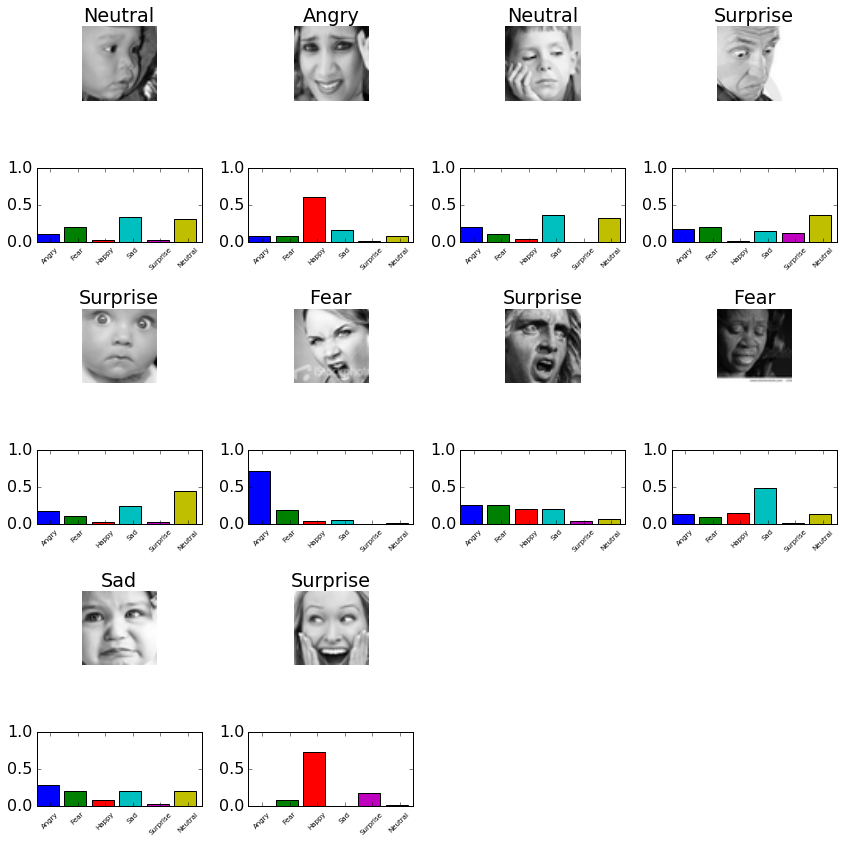

In [27]:
PredTest = modelflip24.predict(Xtest)
data = Data(df[(df['emotion']!=1)&(df['Usage']=='PrivateTest')])
f = lambda x: x-1 if x>1 else x
fv = np.vectorize(f)
data.data_emotion = fv(data.data_emotion)

# see some misclassed images
misclass = PredTest.argmax(axis=1)!=data.data_emotion
np.sum(misclass)
misclass_array, = np.where(misclass==True)
misclass_list = list(np.random.choice(misclass_array,10))
data.ViewEmotionPredictions('PrivateTest',misclass_list,PredTest)

### Model 48

For the final model, we do not zoom the images during the data preprocessing, so the images have size 48x48. Besides, we increse the number of filters to 32 and the number of neurons in the fully connected layer to 512. Apart from that, the model remain unchanged.

In [28]:
data = Data(df[df['emotion']!=1])
f = lambda x: x-1 if x>1 else x
fv = np.vectorize(f)
data.data_emotion = fv(data.data_emotion)
print("flip")
data.FlipTrain('Training') # create 'Training flip'
data.SubstractMean()
data.Normalization()
data.nb_example
# set inputs and outputs
Xtrain, YtrainBin = data.CreateUsageSet(['Training','Training flip']) # add 'Training flip'
Xcv, YcvBin = data.CreateUsageSet('PublicTest')
Xtest, YtestBin = data.CreateUsageSet('PrivateTest')

flip


In [35]:
### parameters CNN ###
batch_size = 128
nb_epoch = 3
# input image dimensions
img_rows, img_cols = data.dim,data.dim
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# CNN model
model = Sequential()
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=data.input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(data.nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# Model fitting
history24 = model.fit(Xtrain, YtrainBin, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(Xcv, YcvBin))

Train on 56546 samples, validate on 3533 samples
Epoch 1/3
56546/56546 [==============================] - 390s - loss: 1.4984 - acc: 0.4066 - val_loss: 1.3355 - val_acc: 0.4829
Epoch 2/3
56546/56546 [==============================] - 388s - loss: 1.3060 - acc: 0.4910 - val_loss: 1.2818 - val_acc: 0.4905
Epoch 3/3
56546/56546 [==============================] - 387s - loss: 1.2198 - acc: 0.5308 - val_loss: 1.2308 - val_acc: 0.5188


We still run the model only on 3 epochs due to time and load the model that has been computed on 32 epochs.

In [36]:
modelflip48 = load_model(os.path.join(GIT_PATH,'modelflip48'))
historyflip48 = pickle.load(open( os.path.join(GIT_PATH,'historyflip48'), "rb" ))

In [37]:
scoreCVflip48 = modelflip48.evaluate(Xcv, YcvBin,verbose=0)
scoreTestflip48 = modelflip48.evaluate(Xtest, YtestBin, verbose=0)

# Cross validation score and accuracy
print('CV score:', scoreCVflip48[0])
print('CV accuracy:', scoreCVflip48[1])
# Test score and accuracy
print('Test score:', scoreTestflip48[0])
print('Test accuracy:', scoreTestflip48[1])

CV score: 1.18401140968
CV accuracy: 0.583923011706
Test score: 1.12390372614
Test accuracy: 0.603848330537


             precision    recall  f1-score   support

          0       0.52      0.49      0.51       491
          1       0.50      0.41      0.45       528
          2       0.80      0.80      0.80       879
          3       0.45      0.50      0.47       594
          4       0.79      0.73      0.76       416
          5       0.53      0.60      0.56       626

avg / total       0.61      0.60      0.60      3534



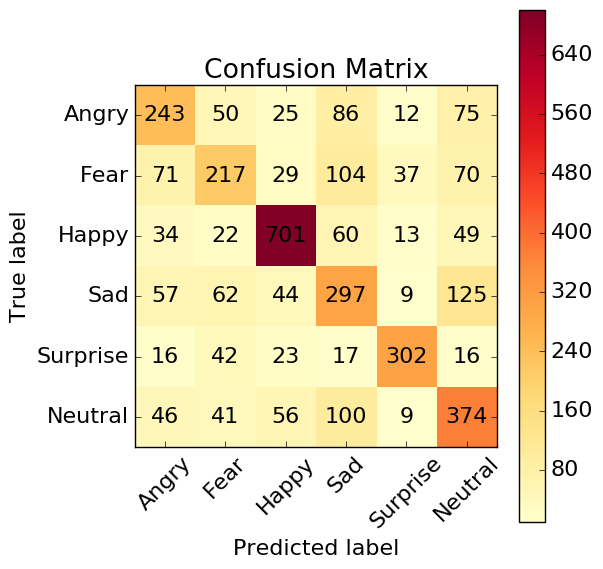

In [38]:
# Model evaluation
Ypredflip48 = modelflip48.predict_classes(x=Xtest, batch_size=batch_size, verbose=0)
Ytestflip48 = data.data_emotion[data.data_usage=='PrivateTest']
labels = dico_emotion.values()

# Classification report
print(metrics.classification_report(Ytestflip48, Ypredflip48))
# Plot confusion matrix
plot_confusion_matrix(Ytestflip48, Ypredflip48)

The final model reaches an accuracy on the test set of **60%**, which represents a important improvement compared to the two previous model. Besides, the model better classifies the "fear" and the "sad" classes that were previously often misclassified.

# Conclusion

Due to a lack of time, we did not keep on working on the dataset enrichment. For instance, we could tilt or translate the training images. With more examples, a model  more complex could be developed. With the addition of convolutional filters by layer, more layers and more neurons would improve the result. Nevertheless, these  refinements must be followed by **computational power**. Indeed, the training of model48 took at least two hours on a standard machine. Keras enables to use **GPU** resources, speeding up considerably the training. 
